<a href="https://colab.research.google.com/github/yonbrand/Gait-Recognition/blob/main/gait_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Gait Segmentation
This code aims to take an acceleration raw data from daily-living, and extract the gait (walking) segmentation during the recording period.
This code is based on the original paper code: https://github.com/qinnzou/Gait-Recognition-Using-Smartphones/blob/master/code/gait-extraction/tf_seg_new.ipynb

Converted from TensorFlow to Pytorch

In [7]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [1]:
import os 
import numpy as np
from numpy import genfromtxt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader


cuda = True if torch.cuda.is_available() else False
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

# Load the data

In [19]:

def read_data(data_path):
  file_names = os.listdir(data_path)
  all_data=np.empty((0,1,6,1024))
  for ind in file_names:
    data=genfromtxt(data_path+'/'+ind, delimiter=',')
    data_n=np.concatenate((data,data),axis=1) #make the data 6-dimensional to fit the network architecture
    data_n=data_n[0:((len(data_n)//1024)*1024)] #remove part of the data for dividing without residual
    sample_data=data_n.reshape((len(data_n)//1024),1,6,1024) #divide the data to samples in length of 1024
    all_data=np.append(all_data,sample_data,axis=0)
    
  return all_data


def read_labels(label_path):
  file_names = os.listdir(label_path)
  all_labels=np.empty((0,1024))
  for ind in file_names:
    labels=genfromtxt(label_path+'/'+ind, delimiter=',')
    labels_n=labels[0:((len(labels)//1024)*1024)] 
    sample_labels=labels_n.reshape((len(labels_n)//1024),1024)
    all_labels=np.append(all_labels,sample_labels,axis=0)
  return all_labels

In [10]:
train_label_path='/content/drive/MyDrive/DL- Danny & Yonatan/Project DL/Labels'
train_data_path='/content/drive/MyDrive/DL- Danny & Yonatan/Project DL/Data'

In [11]:
os.path.isdir(train_data_path)


True

In [20]:
train_data = read_data(train_data_path) 
train_label = read_labels(train_label_path)
#test_data = read_data(test_data_path) 
#test_label = read_label(test_label_path)

In [21]:
print(train_data.shape)
print(train_label.shape)
#print(test_data.shape)
#print(test_label.shape)
#np.save("train_data.npy", train_data)
#np.save("train_label.npy", train_label)
#np.save("test_data.npy", test_data)
#np.save("test_label.npy", test_label)

(10747, 1, 6, 1024)
(10747, 1024)


In [ ]:
train_data=np.load("/content/drive/MyDrive/DL- Danny & Yonatan/Project DL/Paper's data&labels example/train_data.npy").reshape(519,1,1024,6)
train_label=np.load("/content/drive/MyDrive/DL- Danny & Yonatan/Project DL/Paper's data&labels example/train_label.npy").reshape(519,1024)
test_data=np.load("/content/drive/MyDrive/DL- Danny & Yonatan/Project DL/Paper's data&labels example/test_data.npy").reshape(58,1,1024,6)
test_label=np.load("/content/drive/MyDrive/DL- Danny & Yonatan/Project DL/Paper's data&labels example/test_label.npy").reshape(58,1024)

In [ ]:
#ttt = torch.from_numpy(train_data[0:2]).to(device)
#ttt.size()

torch.Size([2, 1, 6, 1024])

Network Architecture

In [22]:
class Network(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1_1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=[1,16])
        self.conv1_2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=[1,16])

        self.conv2_1 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=[1,16])
        self.conv2_2 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=[1,16])

        self.conv3_1 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=[1,16])
        self.conv3_2 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=[1,16])

        self.convTranspose1 = nn.ConvTranspose2d(256, 128, (1, 2), stride=(1, 2))
        self.conv2_5 = nn.Conv2d(in_channels=256, out_channels=128, kernel_size=[1,16])
        self.conv2_6 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=[1,16])

        self.convTranspose2 = nn.ConvTranspose2d(128, 64, (1, 2), stride=(1, 2))
        self.conv1_4 = nn.Conv2d(in_channels=128, out_channels=64, kernel_size=[1,16])
        self.conv1_4_2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=[1,16])
        self.conv1_5 = nn.Conv2d(in_channels=64, out_channels=256, kernel_size=[6,1])
        self.conv1_6 = nn.Conv2d(in_channels=256, out_channels=1, kernel_size=1)

  # define forward function
    def forward(self, x):
        pad_x = nn.ReflectionPad2d((7, 8, 0, 0))(x)

        conv1_1 = F.relu( self.conv1_1(pad_x) )
        conv1_1 = nn.ReflectionPad2d((7, 8, 0, 0))(conv1_1)
        conv1_2 = F.relu( self.conv1_2(conv1_1) )

        conv2_1 = nn.MaxPool2d(kernel_size=[1,2], stride=[1,2])(conv1_2)

        conv2_1 = nn.ReflectionPad2d((7, 8, 0, 0 ))(conv2_1)
        conv2_2 = F.relu( self.conv2_1(conv2_1) )
        conv2_2 = nn.ReflectionPad2d((7, 8, 0, 0 ))(conv2_2)
        conv2_3 = F.relu( self.conv2_2(conv2_2) )

        conv3_1 = nn.MaxPool2d(kernel_size=[1,2], stride=[1,2])(conv2_3)

        conv3_1 = nn.ReflectionPad2d((7, 8, 0, 0))(conv3_1)
        conv3_2 = F.relu( self.conv3_1(conv3_1) )
        conv3_2 = nn.ReflectionPad2d((7, 8, 0, 0))(conv3_2)
        conv3_3 = F.relu( self.conv3_2(conv3_2) )
        conv3_3 = nn.ReflectionPad2d((7, 8, 0, 0))(conv3_3)
        conv3_4 = F.relu( self.conv3_2(conv3_3) )

        conv2_4_1 = self.convTranspose1(conv3_4)
        conv2_4 = torch.cat((conv2_4_1, conv2_3), 1)
        conv2_4 = nn.ReflectionPad2d((7, 8, 0, 0))(conv2_4)
        conv2_5 = F.relu( self.conv2_5(conv2_4) )
        conv2_5 = nn.ReflectionPad2d((7, 8, 0, 0))(conv2_5)
        conv2_6 = F.relu( self.conv2_6(conv2_5) )

        conv1_3_1 = self.convTranspose2(conv2_6)
        conv1_3 = torch.cat((conv1_2, conv1_3_1), 1)
        conv1_3 = nn.ReflectionPad2d((7, 8, 0, 0))(conv1_3)
        conv1_4 = F.relu( self.conv1_4(conv1_3) )
        conv1_4 = nn.ReflectionPad2d((7, 8, 0, 0))(conv1_4)
        conv1_4 = F.relu( self.conv1_4_2(conv1_4) )
        conv1_5 = F.relu( self.conv1_5(conv1_4) )
        conv1_6 = torch.sigmoid( self.conv1_6(conv1_5) )

        out = torch.reshape(conv1_6, (-1, 1024))

        return out

In [24]:
# Training Parameters
learning_rate = 0.00001
num_steps =1 #150
batch_size = 32
display_step = 1
data_len = len(train_data)

In [26]:
tensor_x_train = torch.Tensor(train_data).float().to(device) # transform to torch tensor
tensor_y_train = torch.Tensor(train_label).float().to(device)

train_dataset = TensorDataset(tensor_x_train,tensor_y_train) # create your datset
train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True) # create your dataloader


#tensor_x_test = torch.Tensor(test_data).float().to(device) # transform to torch tensor
#tensor_y_test = torch.Tensor(test_label).float().to(device)

#test_dataset = TensorDataset(tensor_x_test,tensor_y_test) # create your datset
#test_dataloader = DataLoader(test_dataset) # create your dataloader



In [28]:
model = Network().to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [29]:
def my_loss(y_,output_map):
  t0 = y_*torch.log(torch.clamp(output_map,1e-10,1.0))
  t1 = (1-y_)*torch.log(torch.clamp(1-output_map,1e-10,1.0))
  return -torch.mean( t0 + t1)
  #return -torch.mean( y_*torch.log(torch.clamp(output_map,1e-10,1.0)) +(1-y_)*torch.log(torch.clamp(1-output_map,1e-10,1.0)))

In [30]:
def plot_model_loss( train_loss, title="train loss"):
    
    import matplotlib.pyplot as plt

    train = np.array(train_loss)
    #test = np.array(test_loss)

    plt.plot(train, color='blue', label='Training loss') 
    #plt.plot(test, color='red', label='Test loss') 
    
    plt.xlabel('Epoch')  
    plt.ylabel('loss')  

    plt.title(title) 

    plt.legend()
    plt.show()

In [ ]:
def check_acc(model, loader):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in loader:
            features, labels = data
            outputs = model(features)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            
    acc = (100 * correct / total)
    if loader=='train_loader':
      print('Accuracy on the training set is : %.3f %%' % acc)
    elif loader=='test_loader':
      print('Accuracy on the validation set is: %.3f %%' % acc)
    
    return acc

# Train the model

In [31]:
all_train_loss = []
all_test_loss = []

for epoch in range(num_steps):
      
  model.train()
  for batch_idx, (data, labels) in enumerate(train_dataloader):
    
    preds = model(data)

    #loss = F.cross_entropy(preds, labels.to(device))
    loss = my_loss(labels, preds)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    bach_loss = loss.item()

    # if batch_idx % 5 == 0:    
    #      print('[%d, %5d] loss: %.3f' %
    #            (epoch, batch_idx, bach_loss))

  all_train_loss.append(bach_loss)
  model.eval()
  
  # test_preds = model(tensor_x_test)
  # test_loss = my_loss(tensor_y_test, test_preds)
  # all_test_loss.append(test_loss)

  #print("epoch %d,  train loss : %.3f, test loss : %.3f" % (epoch, bach_loss, test_loss))  
  print("epoch %d,  train loss : %.3f," % (epoch, bach_loss))  


  #train_acc.append( check_acc(model, train_loader) )
  #validation_acc.append( check_acc(model, test_loader) ) 

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


epoch 0,  train loss : 0.164,


In [32]:
torch.save(model.state_dict(), 'gait_segmentation.pt') #saving the trained model  

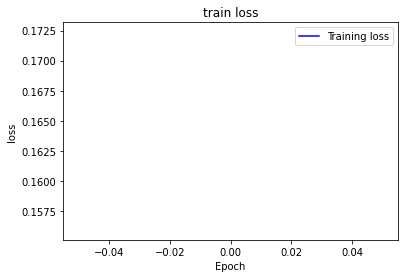

In [33]:
plot_model_loss(all_train_loss)

# Load trained model

In [ ]:
from google.colab import files 
uploaded = files.upload() #upload the trained models files


Saving gait_extraction2.pt to gait_extraction2 (1).pt


In [ ]:
#load one of the models
model=Network().to(device)
model.load_state_dict(torch.load('gait_segmentation.pt')) #load the corresponding model
model.to(device)

Network(
  (conv1_1): Conv2d(1, 64, kernel_size=(1, 16), stride=(1, 1))
  (conv1_2): Conv2d(64, 64, kernel_size=(1, 16), stride=(1, 1))
  (conv2_1): Conv2d(64, 128, kernel_size=(1, 16), stride=(1, 1))
  (conv2_2): Conv2d(128, 128, kernel_size=(1, 16), stride=(1, 1))
  (conv3_1): Conv2d(128, 256, kernel_size=(1, 16), stride=(1, 1))
  (conv3_2): Conv2d(256, 256, kernel_size=(1, 16), stride=(1, 1))
  (convTranspose1): ConvTranspose2d(256, 128, kernel_size=(1, 2), stride=(1, 2))
  (conv2_5): Conv2d(256, 128, kernel_size=(1, 16), stride=(1, 1))
  (conv2_6): Conv2d(128, 128, kernel_size=(1, 16), stride=(1, 1))
  (convTranspose2): ConvTranspose2d(128, 64, kernel_size=(1, 2), stride=(1, 2))
  (conv1_4): Conv2d(128, 64, kernel_size=(1, 16), stride=(1, 1))
  (conv1_4_2): Conv2d(64, 64, kernel_size=(1, 16), stride=(1, 1))
  (conv1_5): Conv2d(64, 256, kernel_size=(6, 1), stride=(1, 1))
  (conv1_6): Conv2d(256, 1, kernel_size=(1, 1), stride=(1, 1))
)

In [ ]:
all_preds=[]
for batch_idx, (data, labels) in enumerate(test_dataloader):

  model.eval()
  preds = model(data)
  all_preds.append(preds)

#all_preds=torch.cat(all_preds, dim=1)

NameError: ignored

In [ ]:
round_preds=torch.round(all_preds).view(-1)

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
x_test_reshape=tensor_x_test.reshape(6,59392)
y_test_reshape=tensor_y_test.reshape(59392)

In [ ]:
acc= torch.sqrt(x_test_reshape[0]**2+x_test_reshape[1]**2+x_test_reshape[2]**2) #the acceleration magnitude

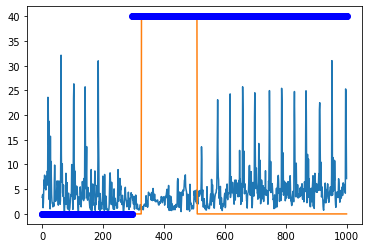

In [ ]:
#visualizing raw_data
plt.plot(acc[:1000].cpu())
plt.plot(y_test_reshape[:1000].cpu()*40)
plt.plot(round_preds[:1000].cpu()*40,'bo')
plt.show()
#plt.savefig('fig.png')

In [ ]:
#extracting only the gait segments for follow-up analysis
gait_segments= acc[round_preds==1]

# Gait Cycle Segmentation

In [ ]:
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

def cycle_seg(data):
  fs=50 #sampling rate, in Hz
  peaks, _=find_peaks(data, distance=0.8*fs)
  threshold=10 #m/s**2
  used_peaks=[]
  for pks in peaks:
    if data[pks]>threshold:
      used_peaks.append(pks)  
  return torch.tensor(used_peaks)

In [ ]:
peaks=cycle_seg(gait_segments.cpu())

In [ ]:
peaks

tensor([  227,   280,   321,   362,   402,   450,   490,   570,   615,   655,
          700,   745,   790,   832,   875,   915,   955,  1000,  1055,  1107,
         1156,  1237,  1319,  1386,  1429,  1469,  1509,  1555,  1601,  1644,
         1685,  1766,  1815,  1906,  1946,  1987,  2037,  2077,  2119,  2159,
         2207,  2247,  2289,  2331,  2382,  3300,  3342,  3415,  3480,  3521,
         3581,  3629,  3703,  3761,  3818,  3890,  3978,  4134,  4216,  4320,
         4390,  4453,  4529,  4581,  4635,  4688,  4733,  4786,  4838,  4889,
         4941,  4993,  5045,  5098,  5152,  5227,  5299,  5360,  5414,  5483,
         5539,  5596,  5652,  5711,  5761,  5819,  5870,  5933,  5989,  6044,
         6103,  6162,  6222,  7218,  7276,  7330,  7390,  7449,  7507,  7644,
         7704,  7754,  7828,  7883,  7937,  7996,  8053,  8102,  8146,  8210,
         8271,  8333,  8506,  8551,  8597,  8651,  8723,  8763,  8804,  8848,
         8891,  8937,  9011,  9067,  9117,  9165,  9233,  9469, 